预测未来销售该项目来源于kaggle中的一场比赛的赛题，数据是由日常销售数据组成的时间序列数据集，该数据集由俄罗斯最大的软件公司之一 - 1C公司提供。提供了包括商店，商品，价格，日销量等连续34个月内的数据，要求预测第35个月的各商店各商品的销量。评价指标为RMSE，我的成绩是0.86964，目前排名736/12764。

## 文章目录
1. 数据分析
2. 数据探索
3. 特征融合
4. 建模训练
5. 结果展示  

参考：https://blog.csdn.net/s09094031/article/details/90347191


 


# 数据分析
比赛链接： https://www.kaggle.com/c/competitive-data-science-predict-future-sales/overview  
目的比较清晰，就是给出前N个月商品的销售信息，我们通过建模训练，拟合预测出第N+1个月商品的销售额。
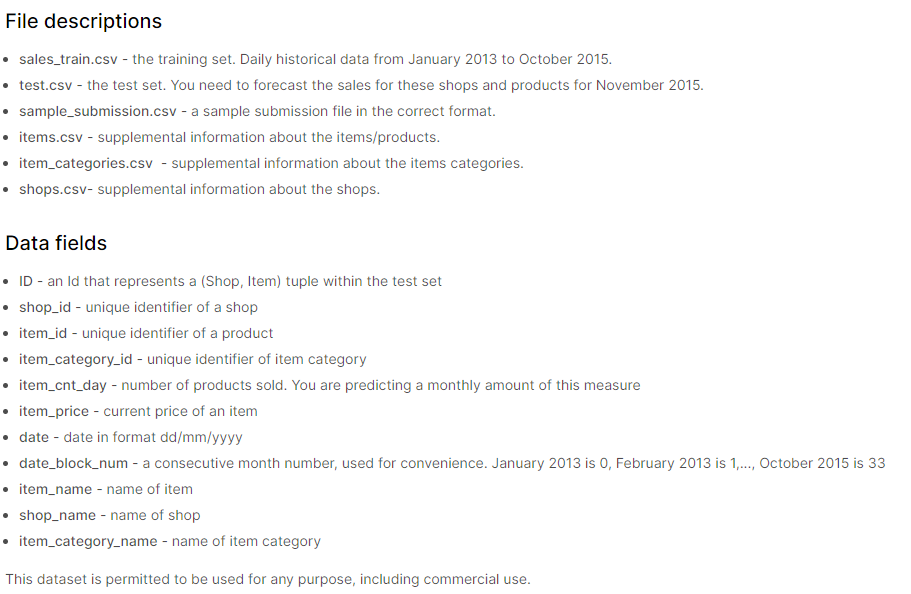

从上述图片中我们可以看到，该赛题提供的数据文件共6个，其中分为训练数据、测试数据和提交样例三部分。

## 训练部分：

sales_train.csv ：记录了从2013年到2015年的历史销售数据
items.csv ：记录了产品的补充信息
items_categories.csv ：记录了产品类别的补充信息
shops.csv ：对于商店的补充信息
## 测试部分：

test.csv：测试数据
## 提交样例：

sample.csv ：提交样例

## 字段总览：

在上面对数据来源和数据种类有了总体的了解之后，我们再来看一下数据中的字段含义。

我们以csv文件为单位，依次讲解。

### sales_train.csv（售卖数据）

date：售卖时间，格式为dd/mm/yyyy  
date-block-num：该字段是一个连续的整型数值，也就是将月份对应的进行了编码。0：2013年1月、1：2013年2月、......、33:2015年10月  
shop_id：代表每一个商店的标识ID  
item_id：每一个产品的标识ID  
item_price：产品的价格  
item-cnt-day：产品当天卖出的数量，我们最终将要预测的是该产品这一个月的销售量  
### items.csv（产品数据）

item_id - 产品的标识ID
item_category_id - 产品的类别标识ID
item_name - 产品的名字
###  items_categories.csv（产品类别数据）

item-category-name：产品类别名字
item-category-id：产品的类别ID，此字段可以和items中的同名字段做连接
###  shops.csv（商店数据）

shop_name：商店名字
shop_id：商店的标识ID，此字段也可以和sales-train.csv中的同名字段做连接
###  test.csv（测试数据）

ID ：该字段比较特殊，他表示的是（shop_id，item-id）组成的元组（tuple）的标识ID
shop_id：商店的标识ID
item_id：产品的标识ID
###  sample.csv（提交样例）

ID：与测试中的字段ID意义一致
item-cnt-month：需要预测的该商品这个月的销售额


## 一.  数据分析

1.1 数据基本处理

- 训练集有六列，分别介绍日期，月份，商店，商品，价格和日销量
 - date,date_block_num,shop_id,item_id,item_price,item_cnt_day
- 测试集有三列，分别是ID，商店，和商品。
 - ID,shop_id,item_id

In [ ]:
from numpy import pi
import pandas as pd

import numpy as np
#  读入数据集  
sales_train =pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')


In [ ]:
# 训练数据的展示
sales_train.head()

In [ ]:
# 测试数据的展示
test.head()

- 训练集，有21807种商品，60个商店。一共2935849 种商品-商店组合。
- 测试集，有5100 种商品，42个商店。刚好就是5100 * 42 = 214200种 商品-商店组合

In [ ]:
print('how many lines in train set:', sales_train.shape)
print('unique items in train set:', sales_train['item_id'].nunique())
print('unique shops in train set:', sales_train['shop_id'].nunique())
print('how many lines in test set:', test.shape)
print('unique items in test set:', test['item_id'].nunique())
print('unique shops in test set:', test['shop_id'].nunique())

查看数据的基本信息以及是否有数据缺失NAN  
数据形状为(2935849, 6)，sales_train中没有missing values，没有nan，

In [ ]:
print('----------head---------')
print(sales_train.head(5))
print('------information------')
print(sales_train.info())
print('-----missing value-----')
print(sales_train.isnull().sum())
print('--------nan value------')
print(sales_train.isna().sum())

1.2 基线模型预测

首先尝试复现基线模型。本次比赛中，基线模型就是用第34个月的销售当作第35个月的销售  0-33 
即将2015年10月的结果当作2015年11月的预测。评估结果应该是1.16777.

- 训练集中的数据是 商品-商店-每天的销售。而要求预测的是商品-商店-每月的销售，因此需要合理使用groupby()和agg()函数。
- 训练集没有出现过的 商品-商店组合，一律填零，最终的结果需要限幅在 [0,20]区间。

In [ ]:
# 基线模型预测
sales_train_subset = sales_train[sales_train['date_block_num'] == 33]
sales_train_subset.head()

In [ ]:
# groupby是类似分组操作，以['shop_id','item_id'] 来进行分类
# 这就是 ['shop_id','item_id','item_cnt_day'] 抽取出来，其中以 ['shop_id','item_id'] 为元组对 'item_cnt_day' 进行求和
# 然后将 'item_cnt_day' 改名为 'item_cnt_month'
grouped = sales_train_subset[['shop_id','item_id','item_cnt_day']].groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'}).reset_index() # eset_indexs是重新设置索引
grouped = grouped.rename(columns={'item_cnt_day' : 'item_cnt_month'})
grouped.head()

In [ ]:
# 这就是简单的讲 训练集最后一个月的数据对应 在 test.csv 中 得到然后保存
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
test = pd.merge(test,grouped, on = ['shop_id','item_id'], how = 'left')
print(test.head())
test['item_cnt_month'] = test['item_cnt_month'].fillna(0).clip(0,20)
print(test.head())
test = test[['ID','item_cnt_month']]
submission = test.set_index('ID')
submission.to_csv('submission_baseline.csv')

1.3 节省存储空间 

&#8195;&#8195;因为后续会做大量的特征提取，对存储空间的消耗较大，而且较大的特征集对于模型训练来说也是个负担。在训练集中可以发现，很多数据的动态范围很小，比如date_block_num,shop_id,item_id,用int16存储就足够了。而Item_price, item_cnt_day 用float32 存储也是足够的。这样就可以在不损失信息的前提下，减少一般的存储空间消耗。结果来看从134.4+ MB,减少到了 61.6+ MB。  
&#8195;&#8195;修改前：  
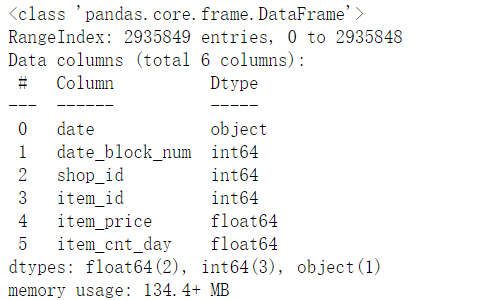

In [ ]:
def downcast_dtypes(df):
    cols_float64 = [c for c in df if df[c].dtype == 'float64']
    cols_int64_32 = [c for c in df if df[c].dtype in ['int64', 'int32']]
    df[cols_float64] = df[cols_float64].astype(np.float32)
    df[cols_int64_32] = df[cols_int64_32].astype(np.int16)
    return df
sales_train = downcast_dtypes(sales_train)
test = downcast_dtypes(test)
print(sales_train.info())

## 二：数据探索

2.1 训练集分析 sales_train

2.1.1 每件商品的销量

我们使用pivot_table来查看每件商品每个月的销量。pivot_table()和groupby()的用途类似，但更加灵活，可以对columns做更多处理。

In [ ]:
# 查看每件商品每个月的销量
sales_by_item_id = sales_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_item_id.columns = sales_by_item_id.columns.droplevel().map(str)
sales_by_item_id = sales_by_item_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_item_id.columns.values[0] = 'item_id'


In [ ]:
sales_by_item_id.tail()

In [ ]:
sales_by_item_id.shape

从上表中可以看出一共有21807件商品。使用sum()可以看到所有商品的总销量根据时间的变化关系。

In [ ]:
# 注释为 自己测试用
# sales_by_item_id['0'].sum()
# sales_by_item_id.sum()[1:]
sales_by_item_id.sum()[1:].plot(legend=True, label="Monthly sum")

分析有多少商品在最近的连续六个月内，没有销量。这些商品有多少出现在测试集中。
- 训练集一共21807种商品，其中有12391种在最近的六个月没有销量。
- 测试集一共5100种商品，其中有164种在训练中最近六个月没有销量，共出现了164 * 42 = 6888次。
- Tips：在最终的预测结果中，我们可以将这些商品的销量大胆地设置为零。

In [ ]:
outdated_items = sales_by_item_id[sales_by_item_id.loc[:,'27':].sum(axis=1)==0]
print('Outdated items:', len(outdated_items))
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
print('unique items in test set:', test['item_id'].nunique())
print('Outdated items in test set:', test[test['item_id'].isin(outdated_items['item_id'])]['item_id'].nunique())


在训练集种有6行，是重复出现的，我们可以删除或者保留，这种数据对结果影响不大。

In [ ]:
# duplicated() 是两行所有元素都是重复的才是重复的
print("duplicated lines in sales_train is", len(sales_train[sales_train.duplicated()]))

In [ ]:
# 如果你想删除的话
sales_train_alter = sales_train.drop_duplicates()             #保留第一个值，返回副本
print(sales_train.shape)
print(sales_train_alter.shape)

2.1.2 每个商品的销量

一共有 60 个商店，坐落在31个城市,城市的信息可以作为商店的一个特征。
这里先分析下哪些商店是最近才开的，哪些是已经关闭了的，同样分析最后六个月的数据。
- shop_id = 36 是新商店
- shop_id = [0 1 8 11 13 17 23 29 30 32 33 40 43 54] 可以认为是已经关闭了。
- Tips：新商店，可以直接用第33个月来预测34个月的销量，因为它没有任何历史数据。而已经关闭的商店，销量可以直接置零

In [ ]:
sales_by_shop_id = sales_train.pivot_table(index=['shop_id'],values=['item_cnt_day'], 
                                        columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
sales_by_shop_id.columns = sales_by_shop_id.columns.droplevel().map(str)
sales_by_shop_id = sales_by_shop_id.reset_index(drop=True).rename_axis(None, axis=1)
sales_by_shop_id.columns.values[0] = 'shop_id'

for i in range(27,34):
    print('Not exists in month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,'0':str(i)].sum(axis=1)==0].unique())

for i in range(27,34):
    print('Shop is outdated for month',i,sales_by_shop_id['shop_id'][sales_by_shop_id.loc[:,str(i):].sum(axis=1)==0].unique())

2.1.3 每类商品的销量

为了能使用商品的类别，需要先读取item_categories的信息，然后添加到sales_train里面

In [ ]:
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_categories = item_categories[['item_id','item_category_id']]

In [ ]:
item_categories.head()

In [ ]:
sales_train_merge_cat = pd.merge(sales_train,item_categories, on = 'item_id', how = 'left')
sales_train_merge_cat.head()

2.1.3 销量和价格的离群值

从sales_train中找到销量和价格的离群值，然后删掉。

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])
print('Sale volume outliers:',sales_train['item_cnt_day'][sales_train['item_cnt_day']>1001].unique())
plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])
print('Sale price outliers:',sales_train['item_price'][sales_train['item_price']>300000].unique())


In [ ]:
# 删掉异常值
sales_train = sales_train[sales_train['item_cnt_day'] <1001]
sales_train = sales_train[sales_train['item_price'] < 300000]
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x = sales_train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x = sales_train['item_price'])


有一个商品的价格是负值，将其填充为median。

In [ ]:
sales_train[sales_train['item_price']<0]

In [ ]:
median = sales_train[(sales_train['date_block_num'] == 4) & (sales_train['shop_id'] == 32)\
                     & (sales_train['item_id'] == 2973) & (sales_train['item_price']>0)].item_price.median()
sales_train.loc[sales_train['item_price']<0,'item_price'] = median
print(median)

2.2 测试集分析

测试集有5100 种商品，42个商店。刚好就是5100 * 42 = 214200种 商品-商店组合。可以分为三大类

- 363种商品在训练集没有出现，363*42=15,246种商品-商店没有数据，约占7%。
- 87550种商品-商店组合是只出现过商品，没出现过组合。约占42%。
- 111404种商品-商店组合是在训练集中完整出现过的。约占51%。


In [ ]:
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
good_sales = test.merge(sales_train, on=['item_id','shop_id'], how='left').dropna()
good_pairs = test[test['ID'].isin(good_sales['ID'])]
no_data_items = test[~(test['item_id'].isin(sales_train['item_id']))]

print('1. Number of good pairs:', len(good_pairs))
print('2. No Data Items:', len(no_data_items))
print('3. Only Item_id Info:', len(test)-len(no_data_items)-len(good_pairs))


In [ ]:
no_data_items.head()

In [ ]:
good_sales.head()

2.3 商品特征

2.3.1 商品信息清洗

商店名里已经包含了很多特征，可以按以下结构分解。

城市 | 类型 | 名称

In [ ]:
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops.head()

经过分析，发现以下商店名为同一个商店，可以合并shop_id.
* 11 => 10
* 1 => 58
* 0 => 57
* 40 => 39  
比如  
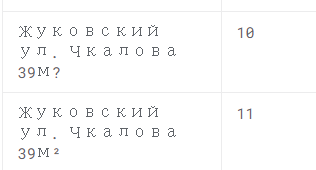
查看测试集，发现 shop id [0,1,11,40] 都不存在。


- shop_id = 0, 1 仅仅存在了两个月，而 shop_id = 57,58 看起来就像是继任者。
- shop_id = 11 仅仅存在于 date_block = 25,而 shop_id = 10 只在那个月没有数据。
- shop_id = 40 仅仅存在于 date_block = [14,25] 而 shop_id = 39 在 date_block = 14 之后一直存在。
- shop_id = 46,商店名中间多了一个空格，会影响到编码，要去掉。 Сергиев Посад ТЦ “7Я”
- 通过商店命名，我发现shop 12 and 55都是网店，并且发现他们的销量的相关度很高，只是不知道怎么用这个信息。

In [ ]:
# 没有被利用
sales12 = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 12 ].values)
sales12 = sales12[:,1:].reshape(-1)
sales55 = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 55 ].values)
sales55 = sales55[:,1:].reshape(-1)
months = np.array(sales_by_shop_id.loc[sales_by_shop_id['shop_id'] == 12 ].columns[1:])
np.corrcoef(sales12,sales55)

In [ ]:
# 给训练集中换名字，测试集不要换的原因是测试集中本身就没有这个 ID
sales_train.loc[sales_train['shop_id'] == 0,'shop_id'] = 57
sales_train.loc[sales_train['shop_id'] == 1,'shop_id'] = 58
sales_train.loc[sales_train['shop_id'] == 11,'shop_id'] = 10
sales_train.loc[sales_train['shop_id'] == 40,'shop_id'] = 39

2.3.2 商店信息编码

In [ ]:

shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]', '').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x else 'трц' if 'трц' in x else 'трк' if 'трк' in x else 'тц' if 'тц' in x else 'тк' if 'тк' in x else 'NO_DATA')
shops.head()

In [ ]:
from sklearn.preprocessing import LabelEncoder
shops['shop_city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])
shops.head()


2.4 商品分类特征

商品类别之间的距离不好确定，使用one hot编码更加合适。

In [ ]:
categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

In [ ]:
lines1 = [26,27,28,29,30,31]
lines2 = [81,82]
for index in lines1:
    category_name = categories.loc[index,'item_category_name']
#    print(category_name)
    category_name = category_name.replace('Игры','Игры -')
#    print(category_name)
    categories.loc[index,'item_category_name'] = category_name
for index in lines2:
    category_name = categories.loc[index,'item_category_name']
#    print(category_name)
    category_name = category_name.replace('Чистые','Чистые -')
#    print(category_name)
    categories.loc[index,'item_category_name'] = category_name
category_name = categories.loc[32,'item_category_name']
#print(category_name)
category_name = category_name.replace('Карты оплаты','Карты оплаты -')
#print(category_name)
categories.loc[32,'item_category_name'] = category_name

In [ ]:
categories.head()

In [ ]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['type'] = categories['split'].map(lambda x:x[0].strip())
categories['subtype'] = categories['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
categories = categories[['item_category_id','type','subtype']]
categories.head()

In [ ]:
categories['cat_type_code'] = LabelEncoder().fit_transform(categories['type'])
categories['cat_subtype_code'] = LabelEncoder().fit_transform(categories['subtype'])
categories.head()

## 3：特征融合

3.1 统计月销量

首先将训练集中的数据统计好月销量

In [ ]:
from itertools import product
import time
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id'] # 列名

for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# 减少数据内存使用，加快运算
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

sales_train['revenue'] = sales_train['item_price'] *  sales_train['item_cnt_day']  # 当前该商品的总收入

groupby = sales_train.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})
groupby.columns = ['item_cnt_month']   # 将每个商品这个月的总销售量求和
groupby.reset_index(inplace=True)
matrix = matrix.merge(groupby, on = ['item_id','shop_id','date_block_num'], how = 'left')
matrix['item_cnt_month'] = matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16)  # 填充 0
matrix.head()

test['date_block_num'] = 34  # 将测试集作为第35 个月放入训练集中   
test['date_block_num'] = test['date_block_num'].astype(np.int8)  # 改变数据内存
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.shape

cols = ['date_block_num','shop_id','item_id']
matrix = pd.concat([matrix, test[['item_id','shop_id','date_block_num']]], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 第 35 month  中每个商品对的月销售量为0


In [ ]:
matrix[matrix['date_block_num']==34]   # 这个月的

这里要确保矩阵里面没有 NA和NULL

In [ ]:
print(matrix['item_cnt_month'].isna().sum())
print(matrix['item_cnt_month'].isnull().sum())

3.2 相关信息融合

将上面得到的商店，商品类别等信息与矩阵融合起来。

In [ ]:
import time
ts = time.time()
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
matrix = matrix.merge(items[['item_id','item_category_id']], on = ['item_id'], how = 'left')
# 这是对商品种类做一个划分
matrix = matrix.merge(categories[['item_category_id','cat_type_code','cat_subtype_code']], on = ['item_category_id'], how = 'left')
# 这是对商店做一个划分
matrix = matrix.merge(shops[['shop_id','shop_city_code','shop_type_code']], on = ['shop_id'], how = 'left')
matrix['shop_city_code'] = matrix['shop_city_code'].astype(np.int8)
matrix['shop_type_code'] = matrix['shop_type_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['cat_type_code'] = matrix['cat_type_code'].astype(np.int8)
matrix['cat_subtype_code'] = matrix['cat_subtype_code'].astype(np.int8)
time.time() - ts

In [ ]:
matrix.head()

对上面的类型做一个额外的补充item_category_id	cat_type_code	cat_subtype_code	shop_city_code	shop_type_code    
- item_category_id ：这是商品种类的 ID  
- cat_type_code ：名称  这和下面两个是商品类别名字做一个拆分分为两部分
- cat_subtype_code ： 子名称  
- shop_city_code ：商店城市  
- shop_type_code ：商店类型  
上面四个是用one-hot编码划分类别的的编码，具体可以卡看上一个章节


In [ ]:
matrix.info()

3.2 历史信息

将产生的信息做了融合。需要通过延迟操作来产生一些历史信息。比如可以将第0-33个月的销量作为第1-34个月的历史特征（延迟一个月）。按照以下说明，一共产生了15种特征。
  - 每个商品-商店组合每个月销量的历史信息，分别延迟[1,2,3,6,12]个月。这应该是最符合直觉的一种操作。
  - 所有商品-商店组合每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每件商品每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每个商店每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每个商品类别每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每个商品类别-商店每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月  
  
以上六种延迟都比较直观，直接针对商品，商店，商品类别。但是销量的变化趋势还可能与商品类别_大类，商店_城市，商品价格，每个月的天数有关，还需要做以下统计和延迟。可以根据模型输出的feature importance来选择和调整这些特征。

  - 每个商品类别_大类每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每个商店_城市每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。
  - 每个商品-商店_城市组合每个月销量均值的历史信息，分别延迟[1,2,3,6,12]个月。  
  
除了以上组合之外，还有以下特征可能有用

  - 每个商品第一次的销量
  - 每个商品最后一次的销量
  - 每个商品_商店组合第一次的销量
  - 每个商品_商店组合最后一次的销量
  - 每个商品的价格变化
  - 每个月的天数

3.2.1 lag operation产生延迟信息，可以选择延迟的月数。

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

3.2.2 月销量（每个商品-商店）的历史信息

针对每个月的商品-商店组合的销量求一个历史信息，分别是1个月、2个月、3个月、6个月、12个月前的销量。这个值和我们要预测的值是同一个数量级，不需要求平均。而且会有很多值会是NAN，因为不存在这样的历史信息，具体原因前面已经分析过

In [ ]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

3.2.3 月销量（所有商品-商店）均值的历史信息

统计每个月的销量，这里的销量是包括了该月的所有商品-商店组合，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


In [ ]:
matrix.head() # date_avg_item_cnt的相关信息

3.2.4 月销量（每件商品）均值和历史特征

统计每件商品在每个月的销量，这里的销量是包括了该月该商品在所有商店的销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
matrix.head() # 

3.2.5 月销量（每个商店）均值和历史特征

统计每个商店在每个月的销量，这里的销量是包括了该月该商店的所有商品的销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

3.2.6 月销量（每个商品类别）均值和历史特征

统计每个商品类别在每个月的销量，这里的销量是包括了该月该商品类别的所有销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
matrix.head()

3.2.7 月销量（商品类别-商店）均值和历史特征

统计每个商品类别-商店在每个月的销量，这里的销量是包括了该月该商品商店_城市的所有销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id','shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_category_id','shop_id'], how='left')
matrix['date_cat_shop_avg_item_cnt'] = matrix['date_cat_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_cat_shop_avg_item_cnt')
matrix.drop(['date_cat_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
matrix.head()

3.2.8 月销量（商品类别_大类）均值和历史特征

统计每个商品类别_大类在每个月的销量，这里的销量是包括了该月该商品类别_大类的所有销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'cat_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','cat_type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


In [ ]:
matrix.head()

3.2.9 月销量（商品-商品类别_大类）均值和历史特征

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id','cat_type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id','cat_type_code'], how='left')
matrix['date_item_type_avg_item_cnt'] = matrix['date_item_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_type_avg_item_cnt')
matrix.drop(['date_item_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
matrix.head()

3.2.10 月销量（商店_城市）均值和历史特征

统计每个商店_城市在每个月的销量，这里的销量是包括了该月该商店_城市的所有销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num',  'shop_city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


In [ ]:
matrix.head()

3.2.11 月销量（商品-商店_城市）均值和历史特征

统计每个商品-商店_城市在每个月的销量，这里的销量是包括了该月该商品-商店_城市的所有销量，所以需要求平均。同求历史信息。

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num','item_id', 'shop_city_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_item_city_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'shop_city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

3.2.12 趋势特征，半年来价格的变化

In [ ]:
ts = time.time()
group = sales_train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6,12]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts


In [ ]:
matrix.head()

3.2.13 每个月天数¶

In [ ]:
matrix['month'] = matrix['date_block_num'] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [ ]:
matrix.head()

3.2.14 开始和结束的销量

Months since the last sale for each shop/item pair and for item only. I use programing approach.

Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.

In [ ]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts


In [ ]:
matrix.head()

In [ ]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

因为使用了12个月作为延迟特征，必然由大量的数据是NA值，将最开始11个月的原始特征删除，并且对于NA值我们需要把它填充为0。

In [ ]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

In [ ]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

In [ ]:
matrix.head()

In [ ]:
#Save dataset  # 看看需要删除哪些数据
# df.drop(['ID'], axis=1, inplace=True, errors='ignore')
matrix.to_pickle('version2.pkl')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import pickle
from itertools import product
from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)



In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

In [ ]:
data = pd.read_pickle('version2.pkl')

In [ ]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)


In [ ]:
del data
gc.collect();

In [ ]:
X_test.tail()

In [ ]:
import lightgbm as lgb

ts = time.time()
train_data = lgb.Dataset(data=X_train, label=Y_train)
valid_data = lgb.Dataset(data=X_valid, label=Y_valid)

time.time() - ts
    
params = {"objective" : "regression", "metric" : "rmse", 'n_estimators':10000, 'early_stopping_rounds':50,
              "num_leaves" : 200, "learning_rate" : 0.01, "bagging_fraction" : 0.9,
              "feature_fraction" : 0.3, "bagging_seed" : 0}
    
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=1000) 
Y_test = lgb_model.predict(X_test).clip(0, 20)


In [ ]:


submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": X_test
})
submission.to_csv('gbm_submission.csv', index=False)

## 版本二
参考链接：https://zhuanlan.zhihu.com/p/356427156

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
%matplotlib inline

读取CSV表格

In [ ]:
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
item_cats = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')

In [ ]:
sales.head()

这个地方我觉得还需要再考虑一下
对 sales 表进行一些数值处理

In [ ]:
train = sales[(sales.item_price<10000)&(sales.item_price>0)]
train = train[sales.item_cnt_day<1001]

In [ ]:
# 0, 57 的值输出
print(shops[shops.shop_id.isin([0, 57])]['shop_name'])
print(shops[shops.shop_id.isin([1, 58])]['shop_name'])
print(shops[shops.shop_id.isin([40, 39])]['shop_name'])
# 是 这两个可能是一个店名，然后可以改为一个
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39

数据增强

In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']
df = [] 
for block_num in train['date_block_num'].unique():
    # 对应月份的 商品和商店 进行笛卡尔集
    # 注意都是在当前月份下面的商店id和产品id的组合，因为这样的组合才有意义。
    cur_shops = train.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = train.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    df.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
# 将两个维度相同的numpy数组竖向拼接。这个就是一个全新的 dataframe
df = pd.DataFrame(np.vstack(df), columns = index_cols,dtype=np.int32)

In [ ]:
df.head()

In [ ]:
# 将 对每个月下，每一个元组的当天销售量也就是item-cnt-day字段进行sum操作
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

In [ ]:
group.head()

In [ ]:
# 结果merge到df中，缺失数据进行0填充
df = pd.merge(df, group, on=index_cols, how='left')

df['item_cnt_month'] = (df['item_cnt_month']
                                .fillna(0)
                                .clip(0,20)
                                .astype(np.float16))

In [ ]:
df.head()

处理测试集

In [ ]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# test 看作第35个月的
df = pd.concat([df, test], ignore_index=True, sort=False, keys=index_cols)
df.fillna(0,inplace=True)

In [ ]:
df    # 这个 ID 该字段比较特殊，他表示的是（shop_id，item-id）组成的元组（tuple）的标识ID

特征工程

In [ ]:

# 特征中又包含了商店的位置信息。 经纬度，地区码
shops['city'] = shops['shop_name'].apply(lambda x: x.split()[0].lower())
shops.loc[shops.city == '!якутск', 'city'] = 'якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

coords = dict()
coords['якутск'] = (62.028098, 129.732555, 4)
coords['адыгея'] = (44.609764, 40.100516, 3)
coords['балашиха'] = (55.8094500, 37.9580600, 1)
coords['волжский'] = (53.4305800, 50.1190000, 3)
coords['вологда'] = (59.2239000, 39.8839800, 2)
coords['воронеж'] = (51.6720400, 39.1843000, 3)
coords['выездная'] = (0, 0, 0)
coords['жуковский'] = (55.5952800, 38.1202800, 1)
coords['интернет-магазин'] = (0, 0, 0)
coords['казань'] = (55.7887400, 49.1221400, 4)
coords['калуга'] = (54.5293000, 36.2754200, 4)
coords['коломна'] = (55.0794400, 38.7783300, 4)
coords['красноярск'] = (56.0183900, 92.8671700, 4)
coords['курск'] = (51.7373300, 36.1873500, 3)
coords['москва'] = (55.7522200, 37.6155600, 1)
coords['мытищи'] = (55.9116300, 37.7307600, 1)
coords['н.новгород'] = (56.3286700, 44.0020500, 4)
coords['новосибирск'] = (55.0415000, 82.9346000, 4)
coords['омск'] = (54.9924400, 73.3685900, 4)
coords['ростовнадону'] = (47.2313500, 39.7232800, 3)
coords['спб'] = (59.9386300, 30.3141300, 2)
coords['самара'] = (53.2000700, 50.1500000, 4)
coords['сергиев'] = (56.3000000, 38.1333300, 4)
coords['сургут'] = (61.2500000, 73.4166700, 4)
coords['томск'] = (56.4977100, 84.9743700, 4)
coords['тюмень'] = (57.1522200, 65.5272200, 4)
coords['уфа'] = (54.7430600, 55.9677900, 4)
coords['химки'] = (55.8970400, 37.4296900, 1)
coords['цифровой'] = (0, 0, 0)
coords['чехов'] = (55.1477000, 37.4772800, 4)
coords['ярославль'] = (57.6298700, 39.8736800, 2) 

shops['city_coord_1'] = shops['city'].apply(lambda x: coords[x][0])
shops['city_coord_2'] = shops['city'].apply(lambda x: coords[x][1])
shops['country_part'] = shops['city'].apply(lambda x: coords[x][2])
shops = shops[['shop_id', 'city_code', 'city_coord_1', 'city_coord_2', 'country_part']]
df = pd.merge(df, shops, on=['shop_id'], how='left')


In [ ]:
df

商品的特征

前面提到了商品的信息主要在item和item_categories两个文件中。那么baseline中主要做的就是提取类别特征，并进行类别编码。

In [ ]:
# 这里字典的意思不太了解
map_dict = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители',
            'PC ': 'Аксессуары',
            'Служебные': 'Служебные '
            }

items = pd.merge(items, item_cats, on='item_category_id')

items['item_category'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items['item_category'] = items['item_category'].apply(lambda x: map_dict[x] if x in map_dict.keys() else x)
items['item_category_common'] = LabelEncoder().fit_transform(items['item_category'])

items['item_category_code'] = LabelEncoder().fit_transform(items['item_category_name'])
items = items[['item_id', 'item_category_common', 'item_category_code']]
df = pd.merge(df, items, on=['item_id'], how='left')

In [ ]:
df

时间特征

此处的时间特征就是就是提取周数、包括这个月的第几天

In [ ]:
# 常规手段？？
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    days_in_month = calendar.monthrange(year, month)[1]
    return weeknd_count, days_in_month, month

map_dict = {i: count_days(i) for i in range(35)}

df['weeknd_count'] = df['date_block_num'].apply(lambda x: map_dict[x][0])
df['days_in_month'] = df['date_block_num'].apply(lambda x: map_dict[x][1])

In [ ]:
df

历史售卖情况特征信息  后面再看一下

主要得思想如下：

1. 标记出哪些商品是第一次上市，哪些不是
2. 标记出哪些商品是第一次卖出的，那些不是


In [ ]:
# 标记出哪些商品是第一次上市，哪些不是
first_item_block = df.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1
# 标记出哪些商品是第一次卖出的，那些不是
first_shop_item_buy_block = df[df['item_cnt_month'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

In [ ]:
df = pd.merge(df, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
df = pd.merge(df, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

df['first_date_block_num'].fillna(100, inplace=True)
df['shop_item_sold_before'] = (df['first_date_block_num'] < df['date_block_num']).astype('int8')
df.drop(['first_date_block_num'], axis=1, inplace=True)

df['item_first_interaction'].fillna(0, inplace=True)
df['shop_item_sold_before'].fillna(0, inplace=True)
 
df['item_first_interaction'] = df['item_first_interaction'].astype('int8')  
df['shop_item_sold_before'] = df['shop_item_sold_before'].astype('int8')

In [ ]:
df

时间滑窗特征

本baseline中最大的提分点、或者说自己眼前一亮的点就是历史信息和时间滑窗特征处理。那我们一起看看原作者是怎么处理的！

In [ ]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    return df

我们将每个月每个商店对应每个产品的前三个月的销售数据滑窗出来：

In [ ]:
df = lag_feature(df, [1, 2, 3], 'item_cnt_month')

对商品的价格也做滑窗操作：

In [ ]:
#Add avg shop/item price

index_cols = ['shop_id', 'item_id', 'date_block_num']
group = train.groupby(index_cols)['item_price'].mean().reset_index().rename(columns={"item_price": "avg_shop_price"}, errors="raise")
df = pd.merge(df, group, on=index_cols, how='left')

df['avg_shop_price'] = (df['avg_shop_price']
                                .fillna(0)
                                .astype(np.float16))

index_cols = ['item_id', 'date_block_num']
group = train.groupby(['date_block_num','item_id'])['item_price'].mean().reset_index().rename(columns={"item_price": "avg_item_price"}, errors="raise")


df = pd.merge(df, group, on=index_cols, how='left')
df['avg_item_price'] = (df['avg_item_price']
                                .fillna(0)
                                .astype(np.float16))

df['item_shop_price_avg'] = (df['avg_shop_price'] - df['avg_item_price']) / df['avg_item_price']
df['item_shop_price_avg'].fillna(0, inplace=True)

df = lag_feature(df, [1, 2, 3], 'item_shop_price_avg')
df.drop(['avg_shop_price', 'avg_item_price', 'item_shop_price_avg'], axis=1, inplace=True)

目标编码处理

In [ ]:
#Add target encoding for items for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id'])['item_cnt_month'].mean().reset_index().rename(columns={"item_cnt_month": "item_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id'], how='left')

df['item_target_enc'] = (df['item_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_target_enc')
df.drop(['item_target_enc'], axis=1, inplace=True)

#Add target encoding for item/city for last 3 months 
item_id_target_mean = df.groupby(['date_block_num','item_id', 'city_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "item_loc_target_enc"}, errors="raise")
df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_id', 'city_code'], how='left')

df['item_loc_target_enc'] = (df['item_loc_target_enc']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'item_loc_target_enc')
df.drop(['item_loc_target_enc'], axis=1, inplace=True)

首次出现的产品如何统计历史信息?  
对于当前月新上市的产品，去统计当前月和该产品类别一致的其他产品的平均销售额，并进行了平滑处理！

In [ ]:
#For new items add avg category sales for last 3 months
item_id_target_mean = df[df['item_first_interaction'] == 1].groupby(['date_block_num','item_category_code'])['item_cnt_month'].mean().reset_index().rename(columns={
    "item_cnt_month": "new_item_cat_avg"}, errors="raise")

df = pd.merge(df, item_id_target_mean, on=['date_block_num','item_category_code'], how='left')

df['new_item_cat_avg'] = (df['new_item_cat_avg']
                                .fillna(0)
                                .astype(np.float16))

df = lag_feature(df, [1, 2, 3], 'new_item_cat_avg')
df.drop(['new_item_cat_avg'], axis=1, inplace=True)

统计过去三个月相似的产品的销售额

In [ ]:
def lag_feature_adv(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)+'_adv']
        shifted['date_block_num'] += i
        shifted['item_id'] -= 1
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)+'_adv'] = df[col+'_lag_'+str(i)+'_adv'].astype('float16')
    return df

df = lag_feature_adv(df, [1, 2, 3], 'item_cnt_month')

删除掉0 1 2 月的数据

In [ ]:
df.fillna(0, inplace=True)
df = df[(df['date_block_num'] > 2)]
df.head()

处理好的特征数据保存成pkl

In [ ]:
#Save dataset
df.drop(['ID'], axis=1, inplace=True, errors='ignore')
df.to_pickle('df.pkl')

## 建模训练

In [ ]:
df = pd.read_pickle('df.pkl') #  version2.pkl df.pkl
df.info()
X_train = df[df.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)


In [ ]:
X_test.tail()

In [ ]:
del df

使用前32个月作为训练集，第33个月作为验证集，然后我们要预测第34个月的数据。

搭建模型

In [ ]:
feature_name = X_train.columns.tolist()
# 超参数
params = {
    'objective': 'mse',  # 目标函数  mse是回归的一种
    'metric': 'rmse',    # 评估函数  
    'num_leaves': 2 ** 7 - 1,  # 叶子节点数   应该是奇数
    'learning_rate': 0.005,    # 学习速率
    'feature_fraction': 0.75,  # 建树的特征选择比例
    'bagging_fraction': 0.75,  #  建树的样本采样比例
    'bagging_freq': 5, # k 意味着每 k 次迭代执行bagging  默认5 
    'seed': 1,
    'verbose': 1  # <0 显示致命的, =0 显示错误 (警告), >0 显示信息  默认1
}

feature_name_indexes = [ 
                        'country_part', 
                        'item_category_common',
                        'item_category_code', 
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=3000,
        valid_sets=(lgb_train, lgb_eval), 
        feature_name = feature_name,
        categorical_feature = feature_name_indexes,
        verbose_eval=5, 
        evals_result = evals_result,
        early_stopping_rounds = 100)   # 如果一个验证集的度量在 early_stopping_round 循环中没有提升, 将停止训练

特征重要度预测

In [ ]:
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

保存结果

In [ ]:
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('gbm_submission1.csv', index=False)

## 使用 XGBoost